In [14]:
# code taken from https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f
# also taken from https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

df=pd.read_csv("C:/Users/Sledgehammer/Desktop/EOS-USD.csv")
print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (1468, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-01,1.031340,1.07176,0.989566,1.00669,1.00669,13613000.0
1,2017-07-02,0.996521,2.87751,0.822648,2.71005,2.71005,320452000.0
2,2017-07-03,2.717390,5.39597,2.632310,4.08664,4.08664,414950016.0
3,2017-07-04,4.098010,4.19124,2.933450,3.37200,3.37200,218559008.0
4,2017-07-05,3.356000,3.52350,2.730130,3.00323,3.00323,124339000.0


In [24]:
df.isnull()
df1 = df.dropna(axis=0, how="any")
df1.shape
# from math import nan
# from datatest import validate, accepted, Extra


# data = [df, float('nan')]
# requirement = {5, 6}

# with accepted(Extra(nan)):
#    validate(data, requirement)


(1464, 7)

In [25]:
# Give 80 percent of rows to training and 20 percent to test, use open through volume
# test taking out adj close later
training_set = df1.iloc[:1120, [1,2,3,5,6]].values
test_set = df1.iloc[280:, [1,2,3,5,6]].values
training_set[0:5,:]

array([[1.03134000e+00, 1.07176000e+00, 9.89566000e-01, 1.00669000e+00,
        1.36130000e+07],
       [9.96521000e-01, 2.87751000e+00, 8.22648000e-01, 2.71005000e+00,
        3.20452000e+08],
       [2.71739000e+00, 5.39597000e+00, 2.63231000e+00, 4.08664000e+00,
        4.14950016e+08],
       [4.09801000e+00, 4.19124000e+00, 2.93345000e+00, 3.37200000e+00,
        2.18559008e+08],
       [3.35600000e+00, 3.52350000e+00, 2.73013000e+00, 3.00323000e+00,
        1.24339000e+08]])

## Min-max scaling for normalization

In [32]:
np.max(training_set[:,0])
print(type(training_set))
type(training_set[0,0])
# Normalize between -1.0 and +1.0
training_set_scaled = np.empty(training_set.shape)
test_set_scaled = np.empty(test_set.shape)
for i in range(5):
    training_set_scaled[:,i] = training_set[:,i]/abs(training_set[:,i]).max()
    test_set_scaled[:,i] = test_set[:,i]/abs(test_set[:,i]).max()
print(training_set[0:5,:])


<class 'numpy.ndarray'>
[[0.04766095 0.04682137 0.05242068 0.0467302  0.0013593 ]
 [0.04605187 0.12570816 0.04357846 0.12579957 0.03199815]
 [0.12557778 0.2357307  0.13944241 0.1897004  0.04143408]
 [0.18937988 0.18310034 0.15539482 0.15652706 0.02182381]
 [0.15508964 0.15392916 0.14462427 0.13940889 0.01241564]]


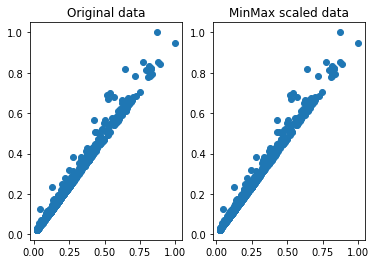

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2)

axes[0].scatter(training_set[:,0], training_set[:,1])
axes[0].set_title("Original data")

axes[1].scatter(training_set_scaled[:,0], training_set_scaled[:,1])
axes[1].set_title("MinMax scaled data")

plt.show()

In [43]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

In [44]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 5s 50ms/step - loss: 0.0304

In [39]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [40]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

ValueError: x and y must have same first dimension, but have shapes (668,) and (459, 1)

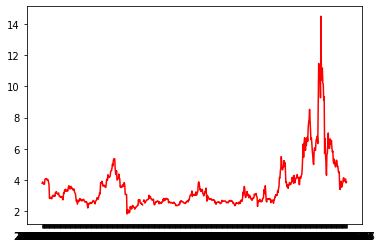

In [41]:
# Visualising the results
plt.plot(df.loc[800:,"Date"],dataset_test.values, color = 'red',
label = 'Real EOS Price')
plt.plot(df.loc[800:, "Date"],predicted_stock_price, color = 'blue',
label = 'Predicted EOS Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('EOS Price Prediction')
plt.xlabel('Time')
plt.ylabel('EOS Price')
plt.legend()
plt.show()

In [ ]:
plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')